In [1]:
# for loading data
import numpy as np
import pandas as pd
import os
# for visualization
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = 'Arial'
import seaborn as sns

from scipy.stats import mannwhitneyu, ttest_ind
# for classification
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, KFold
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve

### Load raw data

In [2]:
raw_info = pd.read_excel('./RawData/Ours/remove_missing.xlsx', sheet_name='Sheet1', index_col=1)
hd_data = raw_info.iloc[:, 1:314]  # 313 samples
uc_data = raw_info.iloc[:, 317:]  # 299 samples
print(hd_data.shape, uc_data.shape)
all_data = pd.concat([hd_data, uc_data], axis=1).T
print(all_data.shape)

# all_data = all_data.reset_index(drop=True)
# HD as 0, UC as 1
all_data['label'] = [0] * hd_data.shape[1] + [1] * uc_data.shape[1]
print(all_data.shape)

flora_orders = hd_data.index.tolist()
mark = flora_orders.index('Lactobacillus')
print(mark)

(62, 313) (62, 299)
(612, 62)
(612, 63)
32


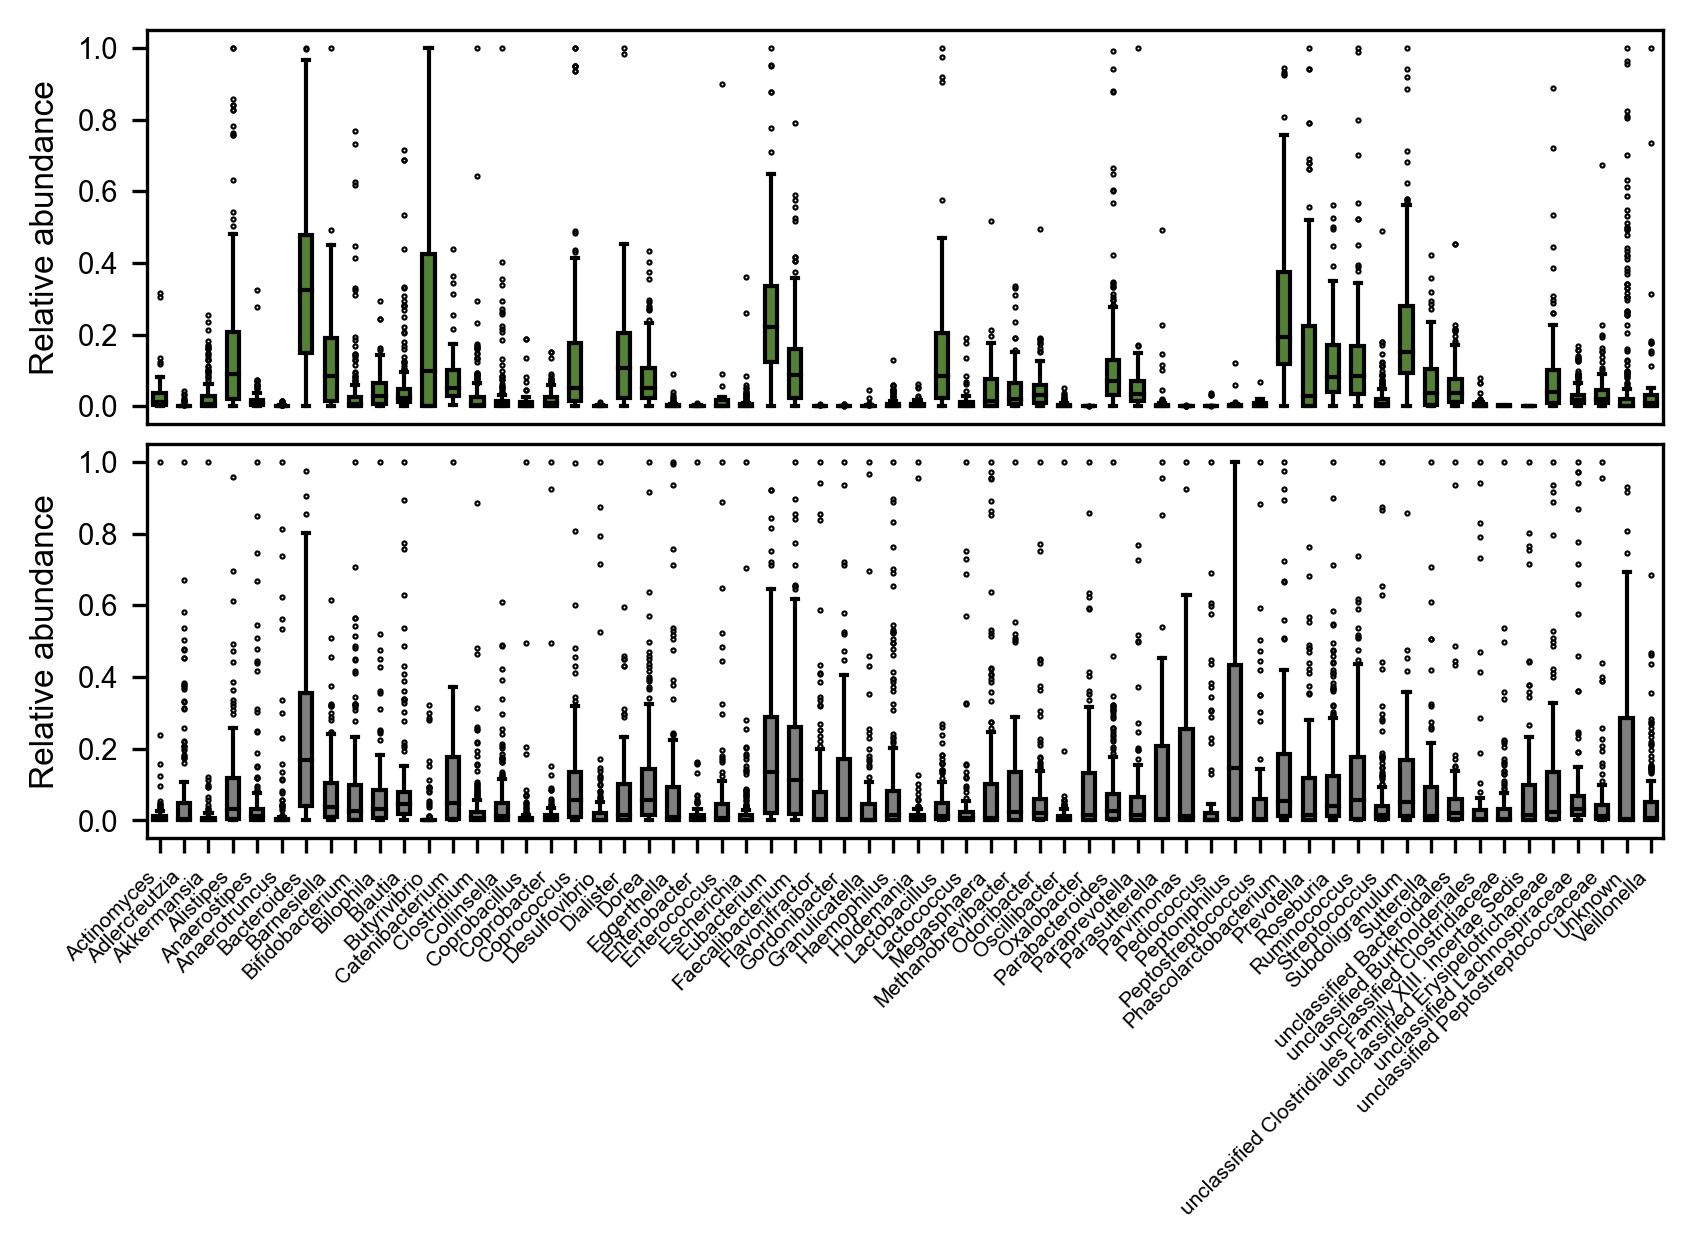

In [3]:
# original distribution of valid values
# plot valid range of HD & UC
hd_values, uc_values = [], []

for i in range(hd_data.shape[0]):
    hd = hd_data.iloc[i, :].values
    hd_valid = hd[~np.isnan(hd)]
    uc = uc_data.iloc[i, :].values
    uc_valid = uc[~np.isnan(uc)]

    # Min max Scaler
    min_value = all_data.iloc[:, i].min(skipna=True)
    max_value = all_data.iloc[:, i].max(skipna=True)
    hd_valid_norm = (hd_valid - min_value) / (max_value - min_value)
    uc_valid_norm = (uc_valid - min_value) / (max_value - min_value)
    hd_values.append(hd_valid_norm)
    uc_values.append(uc_valid_norm)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6.52, 3.5), dpi=300)
plt.subplots_adjust(hspace=0.05)

box1 = ax1.boxplot(hd_values, sym='.', patch_artist=True,
                   flierprops={'markersize':1}, medianprops={'color':'black'})
# ax1.set_title('Relative Abundance Profile of HD', fontsize=15)
ax1.set_ylabel('Relative abundance', fontdict={'fontsize': 8})
ax1.set_xticks([])
ax1.tick_params(labelsize=7)

# ax1.set_xticklabels(flora_orders[:36], rotation='vertical')

box2 = ax2.boxplot(uc_values, sym='.', patch_artist=True, 
                   flierprops={'markersize':1}, medianprops={'color':'black'})
# ax2.set_title('Relative Abundance Profile of UC', fontsize=15)
ax2.tick_params(labelsize=7)
flora_orders_ = [f if ' (' not in f else f.split(' (')[0] for f in flora_orders]
ax2.set_xticklabels(flora_orders_, rotation=45, ha='right', fontdict={'fontsize':5})
ax2.set_ylabel('Relative abundance', fontdict={'fontsize': 8})

for patch in box1['boxes']:
    patch.set_facecolor([84/255,130/255,53/255])
for patch in box2['boxes']:
    patch.set_facecolor([127/255,127/255,127/255])

plt.savefig('./figures/GMrepo_boxplot.png', dpi=300, bbox_inches='tight')
plt.show()

### Traditional methods
+ T test / Wilcoxon test
+ Lefse

0.5392574974043993 Bacteroides
0.5466472186474679 Prevotella
0.5978793396625329 Akkermansia
0.759056191564733 Alistipes
0.7674664921643404 Parabacteroides
0.9142119782549092 Phascolarctobacterium
1.069849289679758 Subdoligranulum
1.1088363113457613 Dialister
1.9898914826514158 Lactobacillus
3.039615097812711 Butyrivibrio


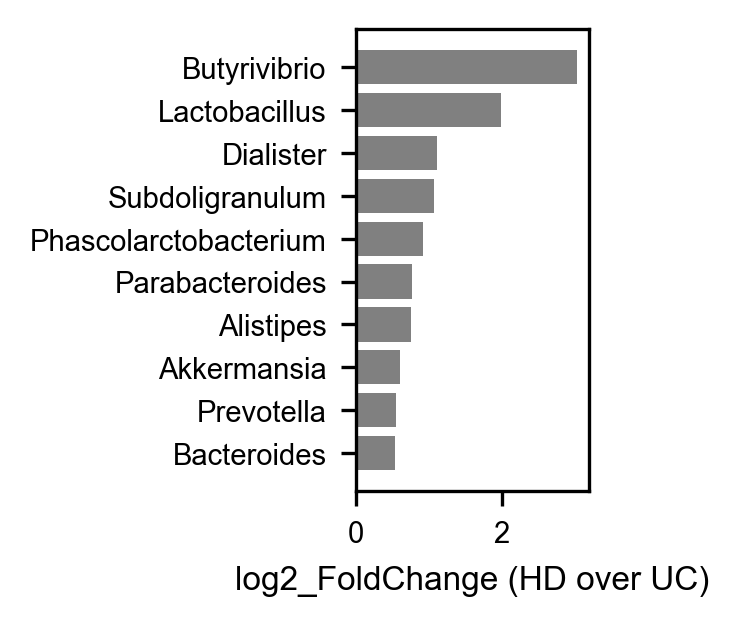

In [4]:
# fold change of each flora
flora_fcs = []
for i in range(hd_data.shape[0]):
    hd = hd_data.iloc[i, :].values
    hd_valid = hd[~np.isnan(hd)]
    uc = uc_data.iloc[i, :].values
    uc_valid = uc[~np.isnan(uc)]

    fc = np.mean(hd_valid) / np.mean(uc_valid)
    flora_fcs.append(fc)

log_flora_fcs = np.log2(flora_fcs)
# log_flora_fcs.argsort()
for index in log_flora_fcs.argsort()[-10:]:
    print(log_flora_fcs[index], flora_orders[index])

neg_log_fcs = np.sort(log_flora_fcs)[-10:]
neg_floras = [flora_orders[index] for index in log_flora_fcs.argsort()[-10:]]
# pos_log_fcs = np.sort(log_flora_fcs)[:5]
# pos_floras = [flora_orders[index] for index in log_flora_fcs.argsort()[:5]]
plt.figure(figsize=(1, 2), dpi=300)
plt.barh(np.arange(10), neg_log_fcs, color='gray')
# plt.barh(np.arange(5), pos_log_fcs)
plt.yticks(np.arange(10), labels= neg_floras)
plt.xlabel('log2_FoldChange (HD over UC)', fontsize=8)
plt.tick_params(labelsize=7)
plt.savefig('./figures/GMrepo_foldchange_top10.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# from scipy.stats import shapiro
# for i in range(hd_data.shape[0]):
#     hd = hd_data.iloc[i, :].values
#     hd_valid = hd[~np.isnan(hd)]
#     uc = uc_data.iloc[i, :].values
#     uc_valid = uc[~np.isnan(uc)]
    # print(shapiro(hd_valid), shapiro(uc_valid))
    # print(len(hd_valid), len(uc_valid))
# 不符合正太分布，使用非参数检验

5.36809837272147 Dialister
5.711809097797406 Akkermansia
5.807226240364647 Phascolarctobacterium
6.621423507935997 Eubacterium
6.683430222005777 Alistipes
7.5684466720602 Butyrivibrio
8.9112119188928 Bacteroides
11.048223357184694 Parabacteroides
14.188213586110495 Subdoligranulum
14.456161526691533 Lactobacillus


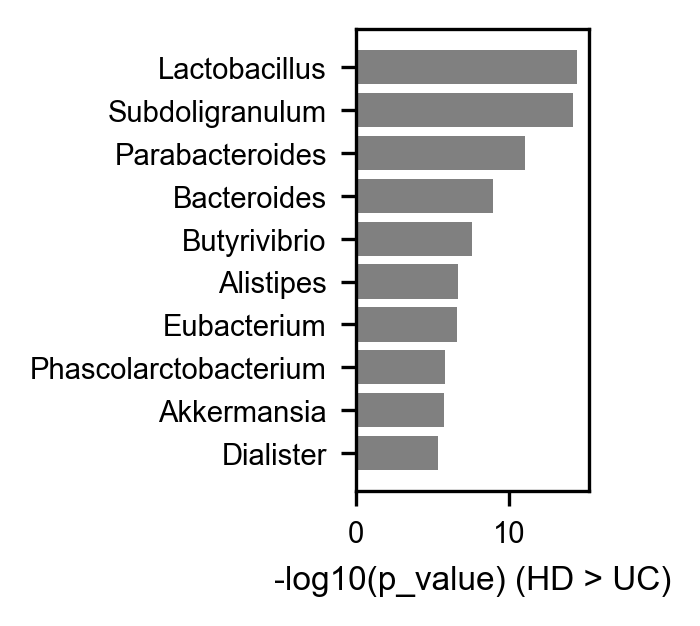

In [5]:
# p_value of Wilcoxon test
flora_p_values = []
for i in range(hd_data.shape[0]):
    hd = hd_data.iloc[i, :].values
    hd_valid = hd[~np.isnan(hd)]
    uc = uc_data.iloc[i, :].values
    uc_valid = uc[~np.isnan(uc)]

    # fc = np.mean(hd_valid) / np.mean(uc_valid)
    _, p = mannwhitneyu(hd_valid, uc_valid, alternative='greater')
    flora_p_values.append(-np.log10(p))
flora_p_values = np.array(flora_p_values)
for index in flora_p_values.argsort()[-10:]:
    print(flora_p_values[index], flora_orders[index])

greater_p_values = np.sort(flora_p_values)[-10:]
greater_floras = [flora_orders[index] for index in flora_p_values.argsort()[-10:]]
# pos_log_fcs = np.sort(log_flora_fcs)[:5]
# pos_floras = [flora_orders[index] for index in log_flora_fcs.argsort()[:5]]
plt.figure(figsize=(1, 2), dpi=300)
plt.barh(np.arange(10), greater_p_values, color='gray')
# plt.barh(np.arange(5), pos_log_fcs)
plt.yticks(np.arange(10), labels= greater_floras)
plt.xlabel('-log10(p_value) (HD > UC)', fontsize=8)
plt.tick_params(labelsize=7)
plt.savefig('./figures/GMrepo_Wilcoxon_pvalue_top10.png', dpi=300, bbox_inches='tight')
plt.show()

In [8]:
# prepare inputs for lefse analysis
# tmp = pd.concat([hd_data, uc_data], axis=1)
# tmp = tmp.fillna(0)
# tmp.to_csv('./tmp/GMrepo_lefse_inputs.txt', sep='\t')

In [9]:
# class information
# with open('./tmp/GMrepo_lefse_inputs_label.txt', 'w') as file:
#     file.write('label\t')
#     for l in ['HD'] * hd_data.shape[1] + ['UC'] * uc_data.shape[1]:
#         file.write(l+ '\t')

### Logistic regression

In [3]:
# using C=10, penalty='l1' as hyperparameters
def classification_final_kfold(all_data, seed, print_res=True):
    features = all_data.iloc[:, :-1].values
    labels = all_data.iloc[:, -1].values

    saved_data = all_data.copy()
    train_aucs = []
    test_aucs = []
    roc_data = []
    train_roc_data = []
    weights_list = []
    # using KFold
    kf = KFold(n_splits=10, shuffle=True, random_state=seed)
    for i, (train_index, test_index) in enumerate(kf.split(features)):
        train_x, test_x = features[train_index], features[test_index]
        train_y, test_y = labels[train_index], labels[test_index]
        split_details = ['train' if i in train_index else 'test' for i in range(len(features))]

        scaler = MinMaxScaler(feature_range=(0,1), clip=True)
        pipe = Pipeline([('impute', SimpleImputer(strategy='constant', fill_value=0.)), ('scaler', scaler)])
        X = pipe.fit_transform(train_x)
        test_X = pipe.transform(test_x)

        # train_idx, test_idx, train_y, test_y = train_test_split(np.arange(len(features)), labels, test_size=0.2, random_state=seed)
        # # save train-test split details
        # split_details = ['train' if i in train_idx else 'test' for i in range(len(features))]
        # # perform MinMaxScaler
        # train_x = features[train_idx]
        # test_x = features[test_idx]
    
        model = LogisticRegression(penalty='l1', C=10, solver='liblinear', random_state=seed, max_iter=1000)
        model.fit(X, train_y)

        train_logits = model.predict_proba(X)[:, 1]
        train_auc = roc_auc_score(train_y, train_logits)
        train_aucs.append(train_auc)
        train_fpr, train_tpr, _ = roc_curve(train_y, train_logits)
        
        logits = model.predict_proba(test_X)[:, 1]
        test_auc = roc_auc_score(test_y, logits)
        test_aucs.append(test_auc)
        fpr, tpr, _ = roc_curve(test_y, logits)

        # feature weights
        weights = model.coef_[0]
        argsort_weights = weights.argsort()
        rank = list(argsort_weights).index(mark)
        if print_res:
            print(rank, weights[mark], train_auc, test_auc)

        weights_list.append(weights)
        train_roc_data.append((train_fpr, train_tpr))
        roc_data.append((fpr, tpr))
        saved_data[f'{seed}_fold_{i}'] = split_details
    
    mean_weights = np.stack(weights_list).mean(axis=0)
    rank = mean_weights.argsort()
    if print_res:
        print(np.mean(train_aucs))
        print(np.mean(test_aucs))
        print(list(rank).index(mark))

    return saved_data, roc_data, mean_weights, np.mean(test_aucs), train_roc_data

In [4]:
saved_data, roc_data, mean_weights, mean_auc, train_roc_data = classification_final_kfold(all_data, seed=42, print_res=True)

0 -16.693076732982387 0.9711467259071195 0.9199999999999999
0 -21.887315538851333 0.9734220587651642 0.8885416666666667
0 -15.63599332030176 0.9655467720685111 0.9782608695652174
0 -16.552148142348074 0.9680999894414529 0.9417582417582417
0 -15.20511042183377 0.9683315761729047 0.9426406926406926
0 -14.683730722670315 0.9671233238306409 0.9505494505494505
0 -14.38712877285462 0.9696081537811575 0.9466666666666668
1 -16.001874779600406 0.9673431734317344 0.9556277056277057
0 -15.310901211763372 0.9696658233185748 0.9237472766884532
0 -15.38873682433716 0.9676240966397637 0.951508620689655
0.9687911693357023
0.939930119085275
0


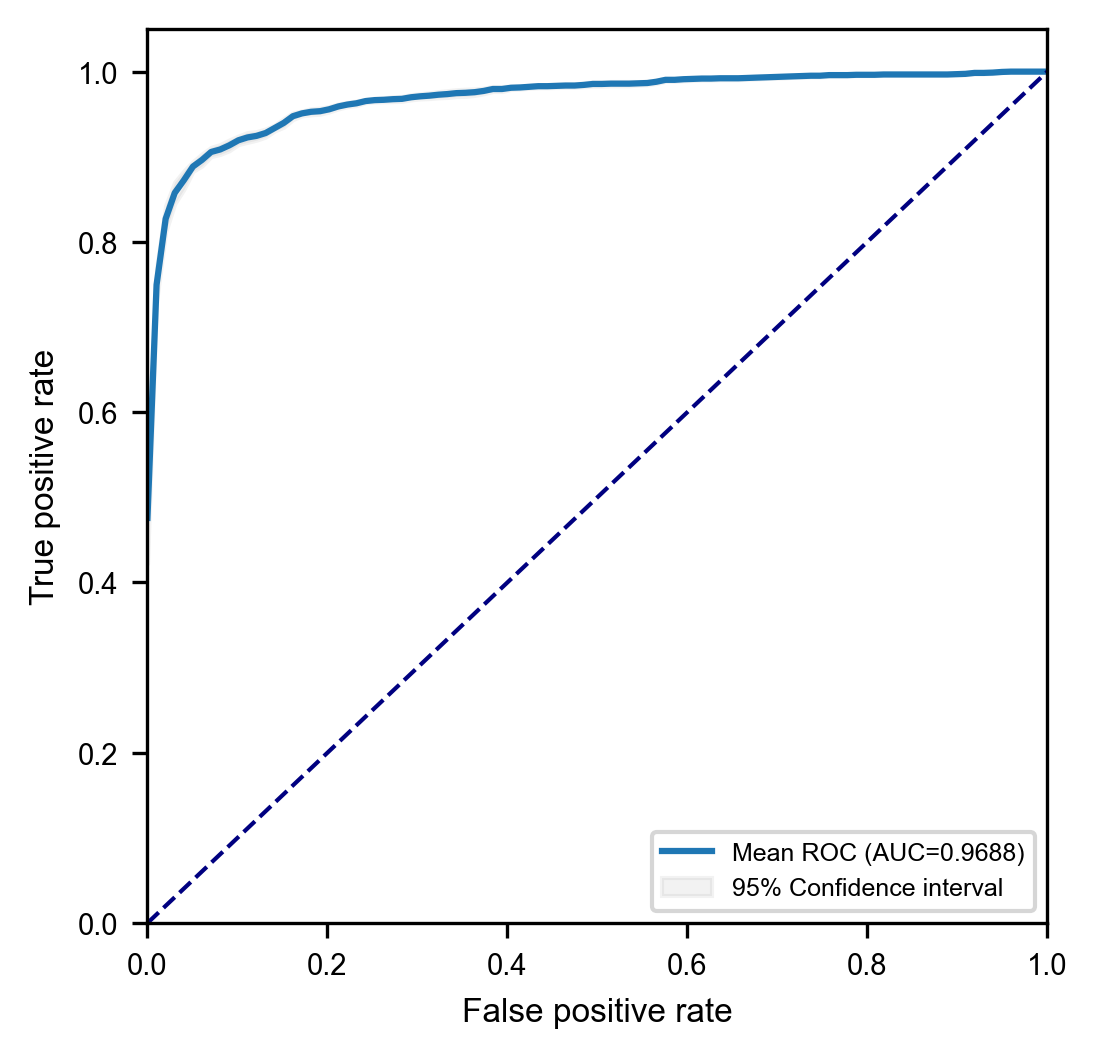

In [5]:
# plot
fig = plt.figure(figsize=(3.87,3.87), dpi=300)

# valid roc
ax = fig.add_subplot(111)
mean_fpr = np.linspace(0, 1, 100)
mean_tpr = np.mean([np.interp(mean_fpr, fpr, tpr) for fpr, tpr in train_roc_data], axis=0)
# 计算95%置信区间
tpr_std = np.std([np.interp(mean_fpr, fpr, tpr) for fpr, tpr in train_roc_data], axis=0)
tpr_upper = np.minimum(mean_tpr + 1.96 * tpr_std / np.sqrt(10), 1)
tpr_lower = mean_tpr - 1.96 * tpr_std / np.sqrt(10)
# 绘制平均ROC曲线
plt.plot(mean_fpr, mean_tpr, label='Mean ROC (AUC=0.9688)')
plt.fill_between(mean_fpr, tpr_lower, tpr_upper, color='grey', alpha=0.1, label='95% Confidence interval')
# plt.fill_between(mean_fpr, tpr_lower, tpr_upper, color='grey', alpha=0.1)

ax.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False positive rate', fontdict={'fontsize':8})
ax.set_ylabel('True positive rate', fontdict={'fontsize':8})
ax.tick_params(labelsize=7)
# ax.set_title('Receiver Operating Curve of Valid Dataset')
# ax.set_title('Receiver Operating Curve of Test Dataset')
ax.legend(fontsize=6, loc='lower right')

plt.savefig('./figures/GMrepo_mean_train_roc_curve.png', dpi=300)
plt.show()

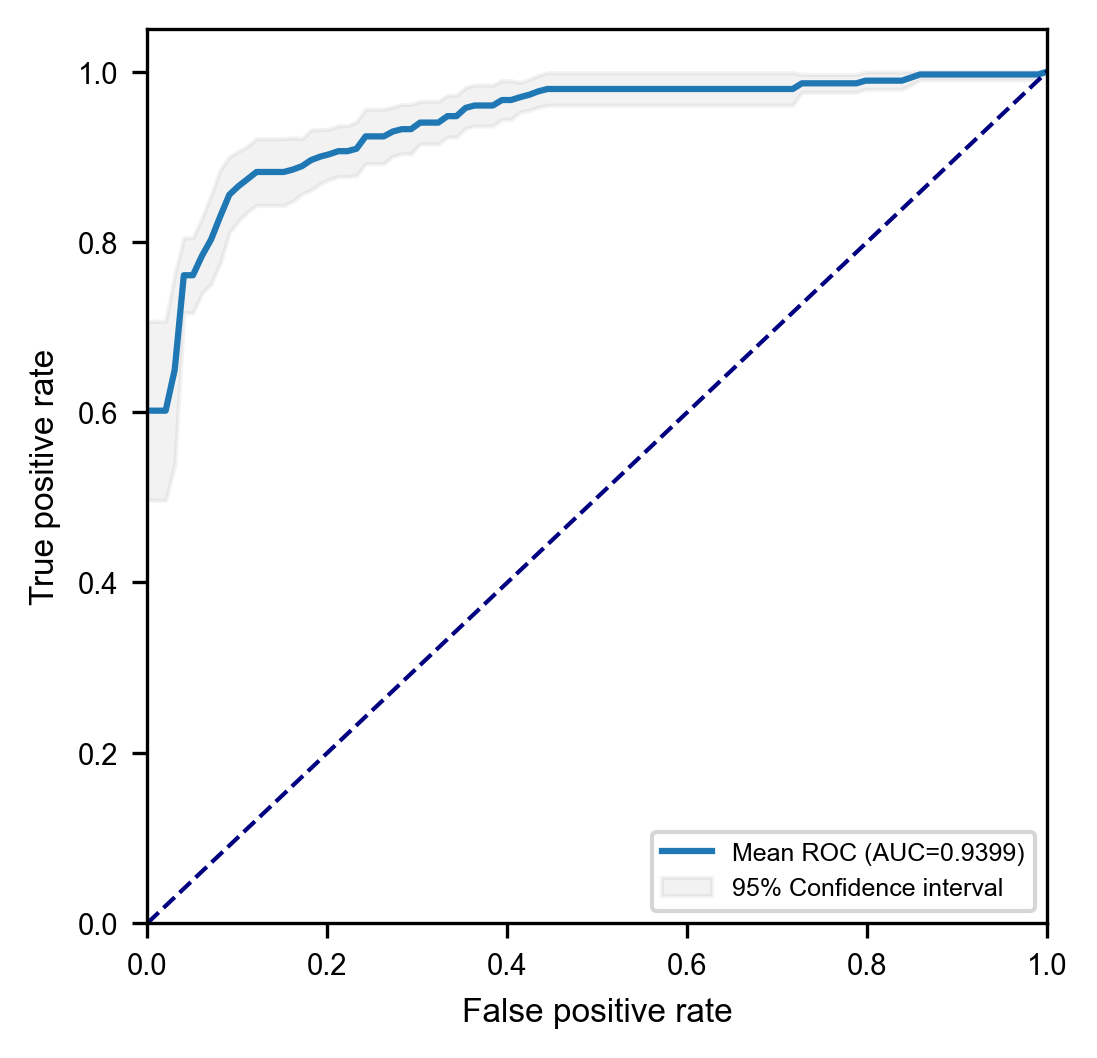

In [6]:
# plot
fig = plt.figure(figsize=(3.87,3.87), dpi=300)

# valid roc
ax = fig.add_subplot(111)
mean_fpr = np.linspace(0, 1, 100)
mean_tpr = np.mean([np.interp(mean_fpr, fpr, tpr) for fpr, tpr in roc_data], axis=0)
# 计算95%置信区间
tpr_std = np.std([np.interp(mean_fpr, fpr, tpr) for fpr, tpr in roc_data], axis=0)
tpr_upper = np.minimum(mean_tpr + 1.96 * tpr_std / np.sqrt(10), 1)
tpr_lower = mean_tpr - 1.96 * tpr_std / np.sqrt(10)
# 绘制平均ROC曲线
plt.plot(mean_fpr, mean_tpr, label='Mean ROC (AUC=0.9399)')
plt.fill_between(mean_fpr, tpr_lower, tpr_upper, color='grey', alpha=0.1, label='95% Confidence interval')
# plt.fill_between(mean_fpr, tpr_lower, tpr_upper, color='grey', alpha=0.1)

ax.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False positive rate', fontdict={'fontsize':8})
ax.set_ylabel('True positive rate', fontdict={'fontsize':8})
ax.tick_params(labelsize=7)
# ax.set_title('Receiver Operating Curve of Valid Dataset')
# ax.set_title('Receiver Operating Curve of Test Dataset')
ax.legend(fontsize=6, loc='lower right')

plt.savefig('./figures/GMrepo_mean_roc_curve.png', dpi=300)
plt.show()

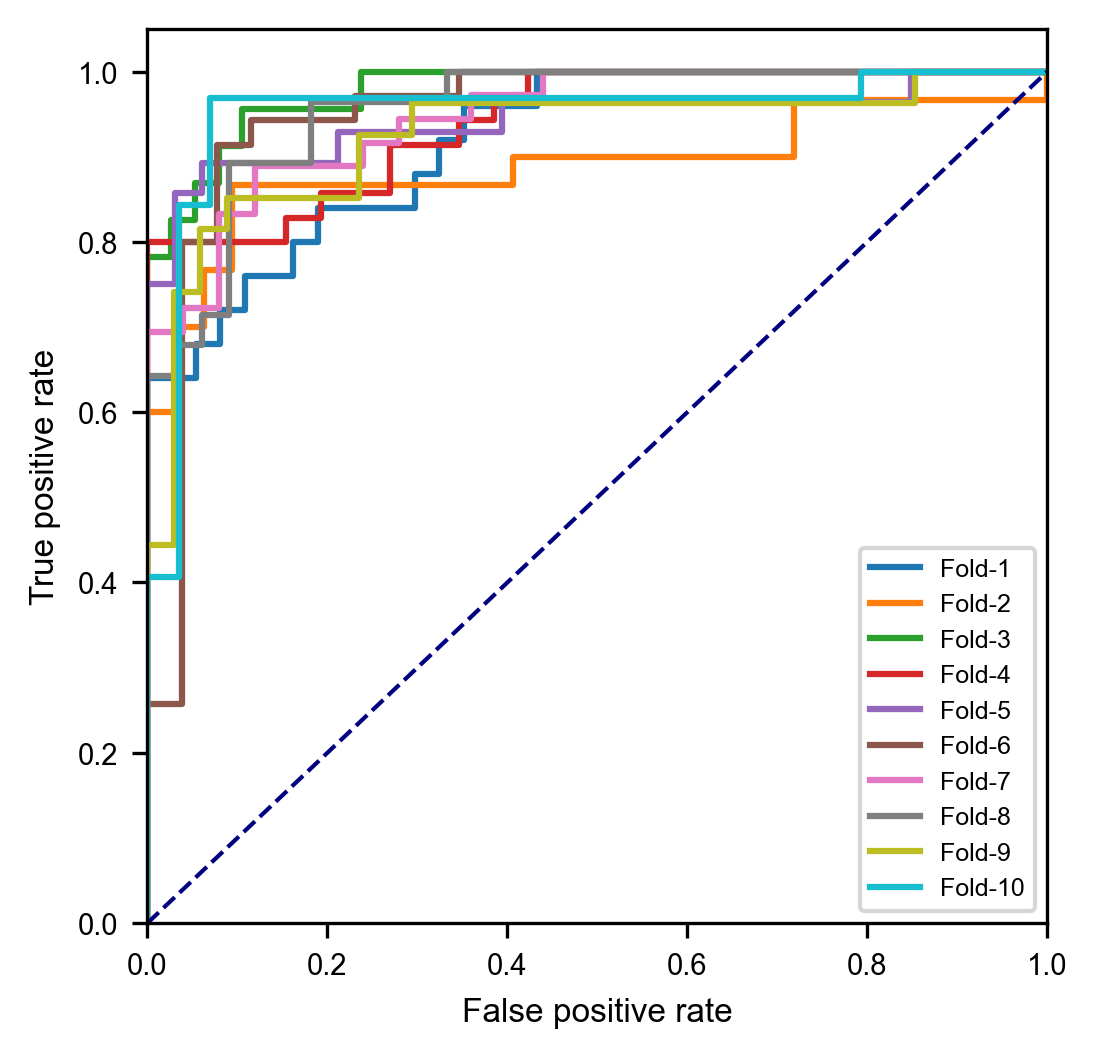

In [8]:
# plot
fig = plt.figure(figsize=(3.87,3.87), dpi=300)

# valid roc
ax = fig.add_subplot(111)
for k, d in enumerate(roc_data,1):
    ax.plot(d[0], d[1], label=f'Fold-{k}')  #  (auc={auc:.4f})
ax.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False positive rate', fontdict={'fontsize':8})
ax.set_ylabel('True positive rate', fontdict={'fontsize':8})
ax.tick_params(labelsize=7)
# ax.set_title('Receiver Operating Curve of Valid Dataset')
# ax.set_title('Receiver Operating Curve of Test Dataset')
ax.legend(fontsize=6)

plt.savefig('./figures/GMrepo_roc_curve.png', dpi=300)
plt.show()

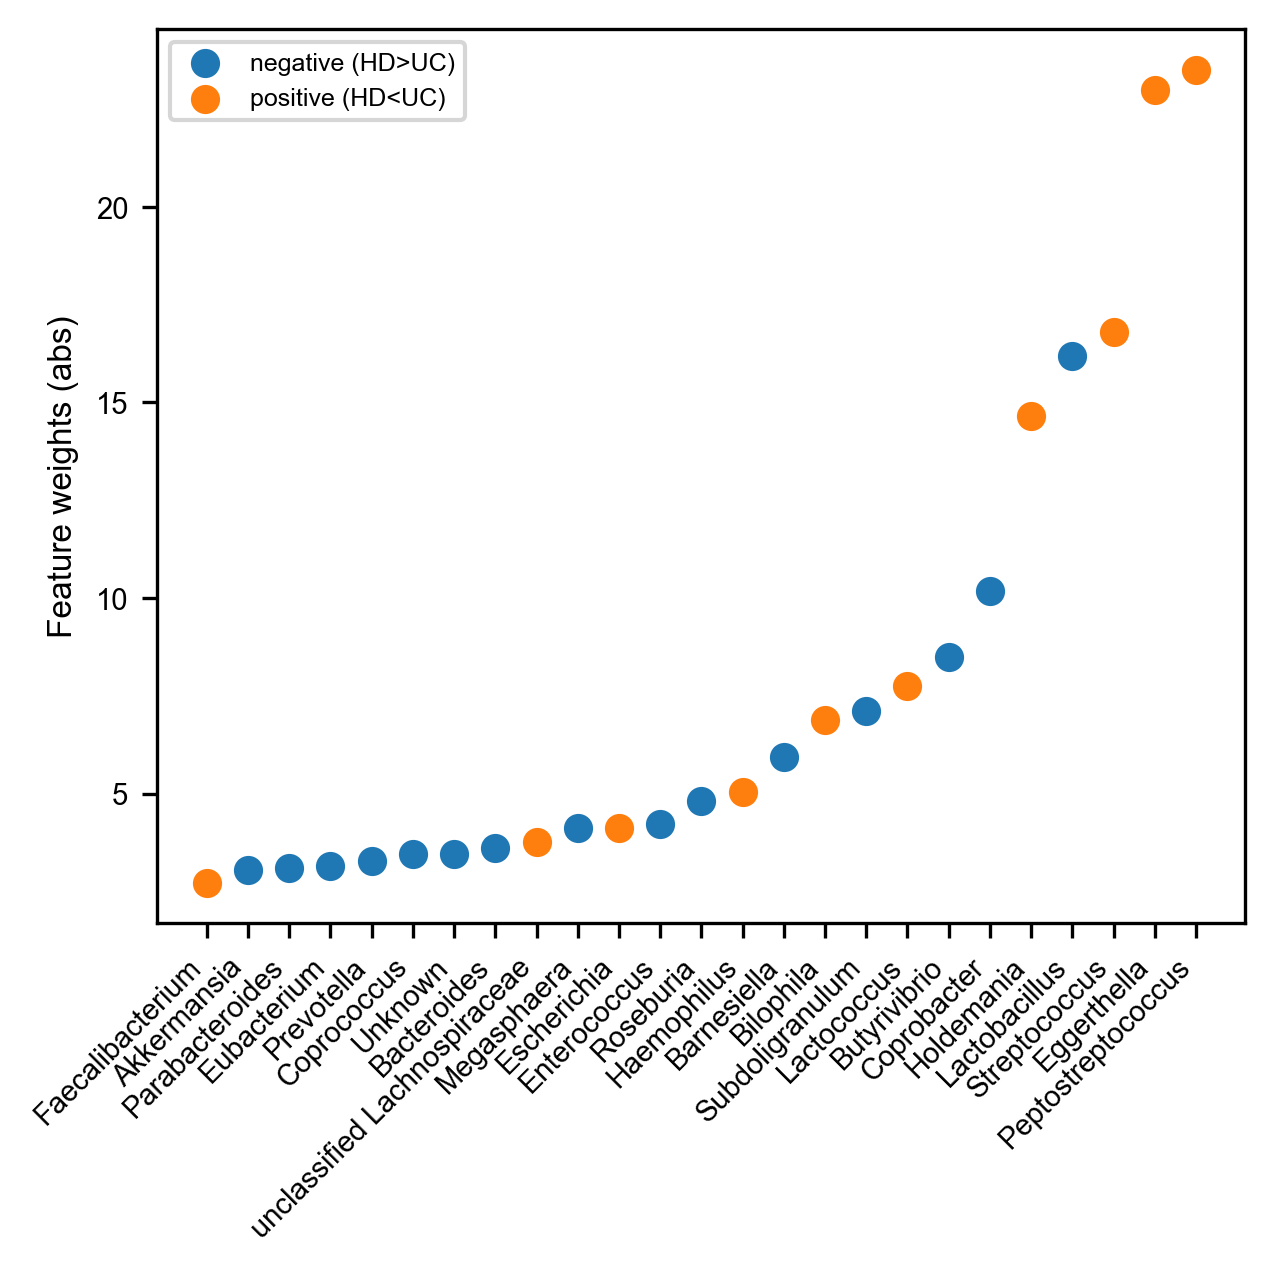

In [9]:
abs_rank = np.abs(mean_weights).argsort()

x_labels = []
pos_y, pos_x, neg_y, neg_x = [], [], [], []
for i, index in enumerate(abs_rank[-25:]):
    x_labels.append(flora_orders[index])
    if mean_weights[index] > 0:
        pos_y.append(mean_weights[index])
        pos_x.append(i)
    else:
        neg_y.append(-mean_weights[index])
        neg_x.append(i)

plt.figure(figsize=(4.68,3.87), dpi=300)
plt.scatter(neg_x, neg_y, label='negative (HD>UC)')
plt.scatter(pos_x, pos_y, label='positive (HD<UC)')
plt.legend(fontsize=6)
plt.xticks(list(range(len(x_labels))), x_labels, rotation=45, ha='right')
plt.ylabel('Feature weights (abs)', fontdict={'fontsize':8})
plt.tick_params(labelsize=7)
# plt.title('Mean Feature weights (Top20)', fontdict={'fontsize': 9})

plt.savefig('./figures/GMrepo_feature_rank_top25.png', dpi=300, bbox_inches='tight')
plt.show()

In [10]:
# top 10 and bottom 10 features
[flora_orders[rnk] for rnk in mean_weights.argsort()[:10]]  # big to small

['Lactobacillus',
 'Coprobacter',
 'Butyrivibrio',
 'Subdoligranulum',
 'Barnesiella',
 'Roseburia',
 'Enterococcus',
 'Megasphaera',
 'Bacteroides',
 'Unknown']

In [11]:
[flora_orders[rnk] for rnk in mean_weights.argsort()[-10:]]  # small to big

['Faecalibacterium',
 'unclassified Lachnospiraceae',
 'Escherichia',
 'Haemophilus',
 'Bilophila',
 'Lactococcus',
 'Holdemania',
 'Streptococcus',
 'Eggerthella',
 'Peptostreptococcus']

In [12]:
saved_data.to_csv('./model/GMrepo_train_test_data.csv')

In [13]:
# repeat for 1000 times
from tqdm import tqdm
mean_weights_list = []
aucs = []
for seed in tqdm(np.random.permutation(10000)[:1000]):
    _, _, mean_weights, mean_auc = classification_final_kfold(all_data, seed=seed, print_res=False)
    mean_weights_list.append(mean_weights)
    aucs.append(mean_auc)

100%|██████████| 1000/1000 [04:21<00:00,  3.83it/s]


In [14]:
print(np.mean(aucs), np.std(aucs))

0.9387543012381742 0.003453355310669401


In [15]:
mean_weights = np.stack(mean_weights_list).mean(axis=0)
rank = mean_weights.argsort()
print(list(rank).index(mark))

0


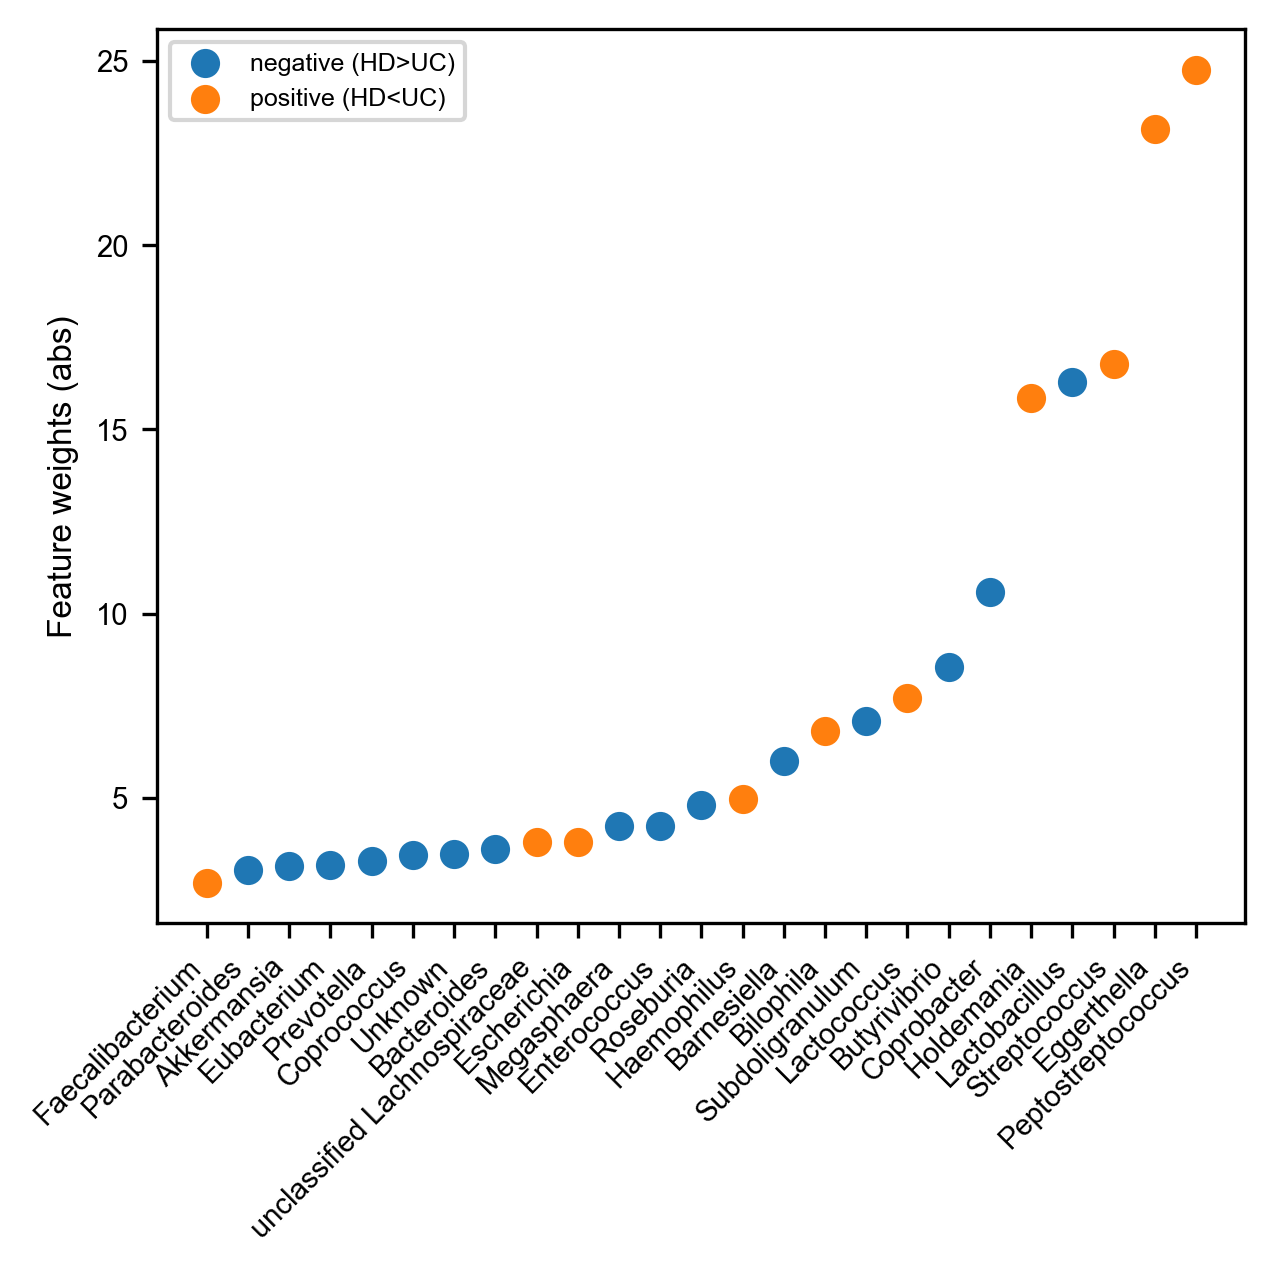

In [16]:
abs_rank = np.abs(mean_weights).argsort()

x_labels = []
pos_y, pos_x, neg_y, neg_x = [], [], [], []
for i, index in enumerate(abs_rank[-25:]):
    x_labels.append(flora_orders[index])
    if mean_weights[index] > 0:
        pos_y.append(mean_weights[index])
        pos_x.append(i)
    else:
        neg_y.append(-mean_weights[index])
        neg_x.append(i)

plt.figure(figsize=(4.68,3.87), dpi=300)
plt.scatter(neg_x, neg_y, label='negative (HD>UC)')
plt.scatter(pos_x, pos_y, label='positive (HD<UC)')
plt.legend(fontsize=6)
plt.xticks(list(range(len(x_labels))), x_labels, rotation=45, ha='right')
plt.ylabel('Feature weights (abs)', fontdict={'fontsize':8})
plt.tick_params(labelsize=7)
# plt.title('Mean Feature weights (Top20)', fontdict={'fontsize': 9})

plt.savefig('./figures/GMrepo_feature_rank_1000times_top25.png', dpi=300, bbox_inches='tight')
plt.show()